# Sélection de variables : une introduction

``` python
import sys
sys.path.insert(1, '../../../../') #insert the utils module
from utils import print_badges

#print_badges(__file__)
print_badges("content/course/modelisation/4_featureselection.qmd")
```

<p class="badges">

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/4_featureselection.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/4_featureselection.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/4_featureselection.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/jupyter-python?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABmodelisation%204_featureselection%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=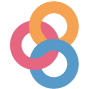" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/4_featureselection.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/modelisation/4_featureselection.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

</p>

</p>

Pour illustrer le travail de données nécessaire pour faire de la sélection de variables,
nous allons partir du même jeu de données que précédemment,
c’est-à-dire les résultats des élections US 2020 présentés dans l’[introduction
de cette partie](https://linogaliana-teaching.netlify.app/modelisation/): les données de vote aux élections présidentielles américaines
croisées à des variables sociodémographiques.
Le code
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/master/content/course/modelisation/get_data.py).

In [2]:
#!pip install --upgrade xlrd #colab bug verson xlrd
#!pip install geopandas

import requests

url = 'https://raw.githubusercontent.com/linogaliana/python-datascientist/master/content/course/modelisation/get_data.py'
r = requests.get(url, allow_redirects=True)
open('getdata.py', 'wb').write(r.content)

import getdata
votes = getdata.create_votes_dataframes()

Jusqu’à présent, nous avons supposé que les variables utiles à la prévision du
vote Républicain étaient connues du modélisateur. Nous n’avons ainsi exploité qu’une partie
limitée des variables disponibles dans nos données. Néanmoins, outre le fléau
computationnel que représenterait la construction d’un modèle avec un grand
nombre de variables, le choix d’un nombre restreint de variables
(modèle parcimonieux) limite le risque de sur-apprentissage.

Comment, dès-lors, choisir le bon nombre de variables et la meilleure
combinaison de ces variables ? Il existe de multiples méthodes, parmi lesquelles :

-   se fonder sur des critères statistiques de performance qui pénalisent les
    modèles non parcimonieux. Par exemple, le BIC.
-   techniques de *backward elimination*.
-   construire des modèles pour lesquels la statistique d’intérêt pénalise l’absence
    de parcimonie (ce que l’on va souhaiter faire ici).

# Principe du LASSO

## Principe général

La classe des modèles de *feature selection* est ainsi très vaste et regroupe
un ensemble très diverse de modèles. Nous allons nous focaliser sur le LASSO
(*Least Absolute Shrinkage and Selection Operator*)
qui est une extension de la régression linéaire qui vise à sélectionner des
modèles *sparses*. Ce type de modèle est central dans le champ du
*Compressed sensing* (où on emploie plutôt le terme
de *L1-regularization* que de LASSO). Le LASSO est un cas particulier des
régressions elastic-net dont un autre cas fameux est la régression *ridge*.
Contrairement à la régression linéaire classique, elles fonctionnent également
dans un cadre où $p>N$, c’est à dire où le nombre de régresseurs est très grand puisque supérieur
au nombre d’observations.

## Pénalisation

En adoptant le principe d’une fonction objectif pénalisée,
le LASSO permet de fixer un certain nombre de coefficients à 0.
Les variables dont la norme est non nulle passent ainsi le test de sélection.

<div class="alert alert-warning" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #ffc10780;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Hint</h3>

Le LASSO est un programme d’optimisation sous contrainte. On cherche à trouver l’estimateur $\beta$ qui minimise l’erreur quadratique (régression linéaire) sous une contrainte additionnelle régularisant les paramètres:
$$
\min_{\beta} \frac{1}{2}\mathbb{E}\bigg( \big( X\beta - y  \big)^2 \bigg) \\
\text{s.t. } \sum_{j=1}^p |\beta_j| \leq t
$$
Ce programme se reformule grâce au Lagrangien est permet ainsi d’obtenir un programme de minimisation plus maniable :
$$
\beta^{\text{LASSO}} = \arg \min_{\beta} \frac{1}{2}\mathbb{E}\bigg( \big( X\beta - y  \big)^2 \bigg) + \alpha \sum_{j=1}^p |\beta_j| = \arg \min_{\beta} ||y-X\beta||_{2}^{2} + \alpha ||\beta||_1
$$
où $\lambda$ est une réécriture de la régularisation précédente.

</div>

## Première régression LASSO

Avant de se lancer dans les exercices, on va éliminer quelques colonnes redondantes,
celles qui concernent les votes des partis concurrents (forcément très
corrélés au vote Républicain…) :

In [3]:
df2 = votes.loc[:,~votes.columns.str.endswith(
  ('_democrat','_green','_other', 'per_point_diff', 'per_dem')
  )]

Nous allons utiliser par la suite les fonctions ou
packages suivants:

In [4]:
# packages utiles
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
import seaborn as sns

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 1 : Premier LASSO</h3>

On cherche toujours à prédire la variable `per_gop`.

1.  Préparez les variables à utiliser.

-   Ne garder que les colonnes numériques (idéalement on transformerait
    les variables non numériques en numériques)
-   Remplacer les valeurs infinies par des NaN et les valeurs manquantes par 0.
-   Standardiser les *features* (c’est-à-dire les variables autres que la variable `per_gop`) avec `StandardScaler`

1.  On cherche toujours à prédire la variable `per_gop`. Créez un échantillon d’entraînement et un échantillon test.
2.  Estimer un modèle LASSO pénalisé avec $alpha = 0.1$. Afficher les valeurs des coefficients. Quelles variables ont une valeur non nulle ?
3.  Montrer que les variables sélectionnées sont parfois très corrélées.
4.  Comparer la performance de ce modèle parcimonieux avec celle d’un modèle avec plus de variables
5.  Utiliser la fonction `lasso_path` pour évaluer le nombre de paramètres sélectionnés par LASSO lorsque $\alpha$
    varie (parcourir $\alpha \in [0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0]$ ).

</div>

In [5]:
#1. Garder uniquement les variables numériques et standardiser.
df2 = votes.loc[:,~votes.columns.str.endswith(('_democrat','_green','_other', 'per_point_diff', 'per_dem'))]
df2 = df2.select_dtypes(include=np.number)
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2 = df2.fillna(0)
col_names = df2.loc[:, df2.columns != 'per_gop'].columns.values
features = df2[col_names]
features = StandardScaler().fit(features.values).transform(features.values)
df2[col_names] = features
#df2.head()

In [6]:
#2. Echantillon d'entraînement et échantillon test
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["per_gop"], axis = 1),
    100*df2[['per_gop']].values.ravel(), test_size=0.2, random_state=0
)

A l’issue de la question 3,
les variables sélectionnées sont :

In [7]:
#3. Estimer un modèle LASSO et afficher les valeurs des coefficients
lasso1 = Lasso(fit_intercept=True, alpha = 0.1).fit(X_train, y_train)

#np.abs(lasso1.coef_)
features_selec = df2.select_dtypes(include=np.number).drop("per_gop", axis = 1).columns[np.abs(lasso1.coef_)>0].tolist()
features_selec
# Le modèle est assez parcimonieux puisque 
# un sous-échantillon de variables sont sélectionnées 

['ALAND',
 'FIPS_y',
 'INTERNATIONAL_MIG_2017',
 'DOMESTIC_MIG_2014',
 'DOMESTIC_MIG_2017',
 'RESIDUAL_2010',
 'RESIDUAL_2019',
 'R_death_2012',
 'R_death_2019',
 'R_NATURAL_INC_2019',
 'R_INTERNATIONAL_MIG_2011',
 'R_DOMESTIC_MIG_2012',
 "Percent of adults with a bachelor's degree or higher, 1990",
 'Percent of adults with a high school diploma only, 2000',
 "Percent of adults with a bachelor's degree or higher, 2000",
 "Percent of adults with a bachelor's degree or higher, 2015-19",
 'Rural_urban_continuum_code_2013',
 'Metro_2013',
 'Unemployment_rate_2002',
 'Unemployment_rate_2003',
 'Unemployment_rate_2012',
 'Rural-urban_Continuum_Code_2003',
 'Rural-urban_Continuum_Code_2013',
 'CI90LB517P_2019',
 'candidatevotes_2016_republican',
 'share_2012_republican',
 'share_2016_republican']

Certaines variables font sens, comme les variables d’éducation par exemple. Notamment, un des meilleurs prédicteurs pour le score des Républicains en 2020 est… le score des Républicains (et mécaniquement des démocrates) en 2016.

Par ailleurs, on sélectionne des variables redondantes. Une phase plus approfondie de nettoyage des données serait en réalité nécessaire.

In [8]:
#4. Corrélations entre les variables sélectionnées
corr = df2[features_selec].corr()

plt.figure()
p = corr.style.background_gradient(cmap='coolwarm', axis=None).format('{:.2f}')
p

<Figure size 672x480 with 0 Axes>

In [9]:
#5. Faire une régression linéaire parcimonieuse et non parcimonieuse

## Régression parcimonieuse
y_pred_parci = lasso1.predict(X_test)
rmse_parci = sklearn.metrics.mean_squared_error(y_test, y_pred_parci, squared = False)
print("rmse_parci : ", rmse_parci)
rsq_parci = sklearn.metrics.r2_score(y_test, y_pred_parci) 
print("rsq_parci : ", rsq_parci)

## Régression non parcimonieuse
ols = LinearRegression().fit(X_train, y_train)
y_pred_nonparci = ols.predict(X_test)
rmse_nonparci = sklearn.metrics.mean_squared_error(y_test, y_pred_nonparci, squared = False)
print("rmse_nonparci : ", rmse_nonparci)
rsq_nonparci = sklearn.metrics.r2_score(y_test, y_pred_nonparci) 
print("rsq_nonparci : ", rsq_nonparci)

# Le modèle parcimonieux est (légèrement) plus performant. 

rmse_parci :  2.138188815474846
rsq_parci :  0.982942279002569
rmse_nonparci :  2.3044404788429023
rsq_nonparci :  0.9801865597219787

In [10]:
### Autres exemples Lino : 
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#print(smf.ols("per_gop ~ share_2016_republican", data = #df2).fit().summary())
# Performance du modèle déjà bonne avec une variable explicative
# Par la suite : se contenter de variables moins bonnes mais qui
# présentent un intérêt pour la sélection
#df2 = votes.loc[:,~votes.columns.str.endswith(("_republican",'_democrat','_green','_other', 'per_point_diff', 'per_dem'))]
# df2 = df[[c for c in df.columns if c not in cols_to_exclude] + ['rep16_frac']]

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 21228.91460989788, tolerance: 1116.0180221013898

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 676693.7583051352, tolerance: 1116.0180221013898

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 493262.72989364434, tolerance: 1116.0180221013898

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning:

Objective did not converge. You might want to increase the 

[  6   7  21  54  86 112 156 154 197 289]

[Text(0.5, 1.0, 'Number variables and regularization parameter ($\\alpha$)'),
 Text(0.5, 0, '$\\alpha$'),
 Text(0, 0.5, 'Nb. de variables')]

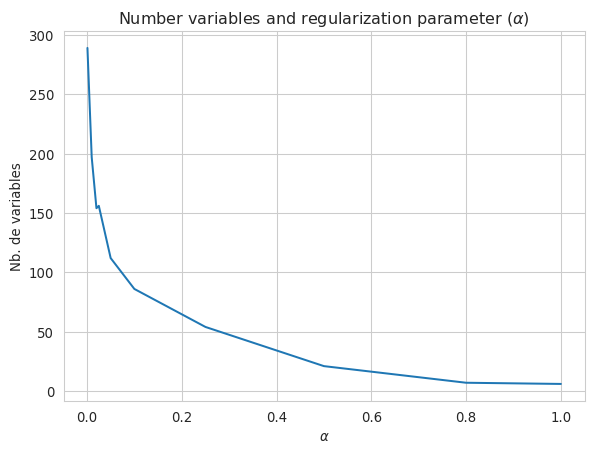

In [11]:
#6. Utilisation de lasso_path
my_alphas = np.array([0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0])
alpha_for_path, coefs_lasso, _ = lasso_path(X_train,y_train,alphas=my_alphas)
#print(coefs_lasso)
nb_non_zero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso,axis=0)
print(nb_non_zero)

## graphique
# Graphe emprunté à http://tutoriels-data-mining.blogspot.com/2018/05/regression-lasso-sous-python.html

sns.set_style("whitegrid")
plt.figure()
p = sns.lineplot(y=nb_non_zero, x=alpha_for_path)
p.set(title = r"Number variables and regularization parameter ($\alpha$)", xlabel=r'$\alpha$', ylabel='Nb. de variables')

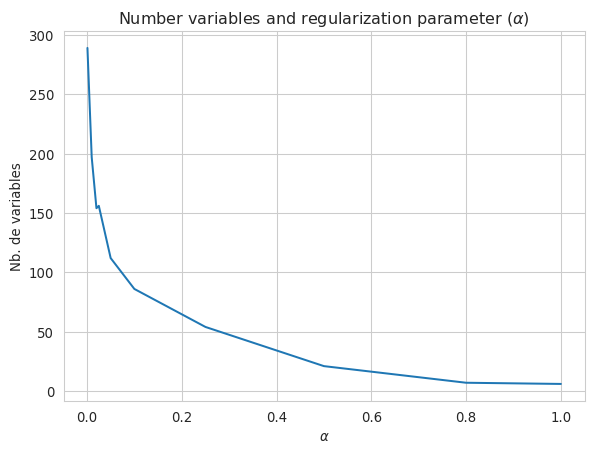

In [12]:
p.figure.get_figure()

On voit que plus $\alpha$ est élevé, moins le modèle sélectionne de variables.

In [13]:
p.figure.get_figure().savefig("featured.png")

## Validation croisée pour sélectionner le modèle

Quel $\alpha$ faut-il privilégier ? Pour cela,
il convient d’effectuer une validation croisée afin de choisir le modèle pour
lequel les variables qui passent la phase de sélection permettent de mieux
prédire le résultat Républicain :

In [14]:
from sklearn.linear_model import LassoCV

df3 = df2.select_dtypes(include=np.number)
df3.replace([np.inf, -np.inf], np.nan, inplace=True)
df3 = df3.fillna(0)
scaler = StandardScaler()
yindex = df3.columns.get_loc("per_gop")
df3_scale = scaler.fit(df3).transform(df3)
# X_train, X_test , y_train, y_test = train_test_split(np.delete(data, yindex, axis = 1),data[:,yindex], test_size=0.2, random_state=0)

lcv = LassoCV(alphas=my_alphas, fit_intercept=False,random_state=0,cv=5).fit(np.delete(df3_scale, yindex, axis = 1), df3_scale[:,yindex])

In [15]:
print("alpha optimal :", lcv.alpha_)

alpha optimal : 0.001

In [16]:
lasso2 = Lasso(fit_intercept=True, alpha = lcv.alpha_).fit(X_train,y_train)
features_selec2 = df2.select_dtypes(include=np.number).drop("per_gop", axis = 1).columns[np.abs(lasso2.coef_)>0].tolist()

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.486e+03, tolerance: 6.352e+01


Les variables sélectionnées sont :

In [17]:
print(features_selec2)

['ALAND', 'AWATER', 'votes_gop', 'diff', 'Rural-urban_Continuum Code_2003', 'Rural-urban_Continuum Code_2013', 'Urban_Influence_Code_2013', 'Economic_typology_2015', 'CENSUS_2010_POP', 'N_POP_CHG_2013', 'N_POP_CHG_2016', 'N_POP_CHG_2017', 'N_POP_CHG_2018', 'N_POP_CHG_2019', 'Births_2011', 'Births_2015', 'Deaths_2015', 'Deaths_2017', 'Deaths_2018', 'NATURAL_INC_2012', 'NATURAL_INC_2013', 'NATURAL_INC_2014', 'NATURAL_INC_2016', 'NATURAL_INC_2018', 'INTERNATIONAL_MIG_2010', 'INTERNATIONAL_MIG_2011', 'INTERNATIONAL_MIG_2012', 'INTERNATIONAL_MIG_2013', 'INTERNATIONAL_MIG_2014', 'INTERNATIONAL_MIG_2015', 'INTERNATIONAL_MIG_2016', 'INTERNATIONAL_MIG_2017', 'INTERNATIONAL_MIG_2018', 'INTERNATIONAL_MIG_2019', 'DOMESTIC_MIG_2010', 'DOMESTIC_MIG_2012', 'DOMESTIC_MIG_2013', 'DOMESTIC_MIG_2015', 'DOMESTIC_MIG_2016', 'DOMESTIC_MIG_2018', 'NET_MIG_2011', 'NET_MIG_2014', 'NET_MIG_2018', 'NET_MIG_2019', 'RESIDUAL_2010', 'RESIDUAL_2011', 'RESIDUAL_2012', 'RESIDUAL_2013', 'RESIDUAL_2014', 'RESIDUAL_2015'

In [18]:
df2.select_dtypes(include=np.number).drop("per_gop", axis = 1).columns[np.abs(lasso2.coef_)>0]
nlasso = sum(np.abs(lasso2.coef_)>0)

``` python
print("Cela correspond à un modèle avec {} variables sélectionnées.".format(int(nlasso)))
```

Cela correspond à un modèle avec 206 variables sélectionnées.

<div class="alert alert-warning" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #ffc10780;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Hint</h3>

Dans le cas où le modèle paraîtrait trop peu parcimonieux, il faudrait revoir la phase de définition des variables pertinentes pour comprendre si des échelles différentes de certaines variables ne seraient pas plus appropriées (par exemple du `log`).

</div>